# In this Notebook we are attempting to predict if a person will win their next fight depending on how they performed on their last 5 fights

## Library Imports

In [125]:
import sys
sys.path.insert(1, '../combined_data')
sys.path.insert(1, '../predict_winner')
from make_career import make_career
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import talos as ta
from talos.model.normalizers import lr_normalizer
from talos.model.hidden_layers import hidden_layers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

## Loading the dataset

In [126]:
features, labels = make_career(N_FIGHT_CAREER=5)
labels = labels.reshape(-1,)

Creating careers using 5 fight intervals and predicting 1 future fights
Original fight data shape: (5062, 153)
Fights 2x shape: (10124, 95)

Features shape: (3220, 5)
Labels shape: (3220, 1)

Features is a 2D matrix with 3220 rows
Each row contains has 5 fights, and each fight has 100 keys

Labels is a 2D matrix with 3220 rows
Each row contains the the prediction for the next 1 fight(s)


In [127]:
print(features.shape)
print(type(features))

(3220, 5)
<class 'numpy.ndarray'>


In [128]:
print(labels.shape)
print(type(labels))

(3220,)
<class 'numpy.ndarray'>


In [129]:
print(labels)

[1. 1. 0. ... 1. 0. 0.]


## Preprocess Features

## Generates np.array of shape (3220, 5 * features)

In [130]:
from sklearn.utils import shuffle

def collapse_n_fights():
    num_cols, cat_cols = get_column_types()
    
    # Collect only the features we want
    new_features = []
    for window in features:
        window_arr = list(window.reshape(1,-1))[0]
        fight_window = np.array([])
        for fight in window_arr:
            fight_arr = np.array([fight[i] for i in num_cols])
            np.nan_to_num(fight_arr, copy=False)
            fight_window = np.append(fight_window, fight_arr)
        new_features.append(fight_window)
    
    new_features, new_labels = shuffle(np.array(new_features), labels)
    X_train, X_test, y_train, y_test = train_test_split(new_features, new_labels, random_state=0, train_size=0.90)
    
    # Scale the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print("X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
    print("X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))
    
    return X_train, X_test, y_train, y_test

### Generates np.array of shape (3220, 5, win?)

## Building a DNN to predict the winner using last n fights

In [131]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)


In [132]:
# Define hyperparameters to use in Grid Search
dnn_params = {'lr': [0.01, 1, 2],
     'first_neuron': [128, 256],
     'hidden_layers': [1, 2],
     'batch_size': [64, 128, 256],
     'epochs': [10, 25],
     'dropout': [0.01, 0.1],
     'optimizer': [Adam],
     'shapes':['funnel'],
     'losses': [binary_crossentropy],
     'activation': [relu],
     'last_activation': [sigmoid]}

In [133]:
# Create the Neural Network
dnn_model = ta.Scan(x=X_train,
               y=y_train,
               model=get_dnn,
               params=dnn_params,
               experiment_name="UFC_5_Fight_Predictor")



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


In [134]:
results_df = dnn_model.data

In [135]:
top_10_dnn = results_df.sort_values(by=['val_accuracy'], ascending=False).head(10)

In [136]:
top_10_dnn

,round_epochs,val_loss,val_accuracy,loss,accuracy,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,last_activation,losses,lr,optimizer,shapes
0,10,0.698924,0.542529,0.69628,0.546351,<function relu at 0x7fe6c06a40d0>,64,0.01,10,128,1,<function sigmoid at 0x7fe6c06a41e0>,<function binary_crossentropy at 0x7fe6c0746ae8>,0.01,<class 'keras.optimizers.Adam'>,funnel


In [137]:
top_10_dnn.to_csv("../model_results/UFC_Predict_5_Fights_DNN.csv")

## Building a CNN to predict the winner using last n fights

In [138]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

print("New: X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
print("New: X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)
New: X_train length (2898, 5, 97), y_train length (2898,)
New: X_test length (322, 5, 97), y_test length (322,)


In [139]:
# Define hyperparameters to use in Grid Search
cnn_params = {'lr': [0.01, 0.1, 1],
     'num_filters': [64, 128],
     'kernel_size': [2],
     'batch_size': [64, 128],
     'epochs': [5, 15],
     'dropout': [0.01],
     'flatten_layer': [100, 150], 
     'optimizer': [Adam],
     'losses': [binary_crossentropy],
     'activation': [relu],
     'last_activation': [sigmoid]}

In [147]:
# Create the Neural Network
cnn_model = ta.Scan(x=X_train,
                y=y_train,
                model=get_cnn,
                params=cnn_params,
                experiment_name="UFC_5_Fight_Predictor_CNN")




  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


In [148]:
results_df = cnn_model.data

In [149]:
top_10_val_cnn = results_df.sort_values(by=['val_accuracy'], ascending=False).head(10)
top_10_acc_cnn = results_df.sort_values(by=['accuracy'], ascending=False).head(10)

In [150]:
top_10_val_cnn

,round_epochs,val_loss,val_accuracy,loss,accuracy,activation,batch_size,dropout,epochs,flatten_layer,kernel_size,last_activation,losses,lr,num_filters,optimizer
0,5,0.709467,0.485057,0.716849,0.495069,<function relu at 0x7fe6c06a40d0>,64,0.01,5,100,2,<function sigmoid at 0x7fe6c06a41e0>,<function binary_crossentropy at 0x7fe6c0746ae8>,0.01,64,<class 'keras.optimizers.Adam'>


In [151]:
top_10_acc_cnn

,round_epochs,val_loss,val_accuracy,loss,accuracy,activation,batch_size,dropout,epochs,flatten_layer,kernel_size,last_activation,losses,lr,num_filters,optimizer
0,5,0.709467,0.485057,0.716849,0.495069,<function relu at 0x7fe6c06a40d0>,64,0.01,5,100,2,<function sigmoid at 0x7fe6c06a41e0>,<function binary_crossentropy at 0x7fe6c0746ae8>,0.01,64,<class 'keras.optimizers.Adam'>


In [153]:
top_10_acc_cnn.to_csv("../model_results/UFC_Predict_5_Fights_CNN_2.csv")

## Building an LSTM to predict the winner using last n fights

In [154]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

print("New: X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
print("New: X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))

X_train length (2898, 485), y_train length (2898,)
X_test length (322, 485), y_test length (322,)
New: X_train length (2898, 5, 97), y_train length (2898,)
New: X_test length (322, 5, 97), y_test length (322,)


Train on 2898 samples, validate on 322 samples
Epoch 1/30
2898/2898 [==============================] - 1s 239us/step - loss: 0.6983 - accuracy: 0.5511 - val_loss: 0.6796 - val_accuracy: 0.5963
Epoch 2/30
2898/2898 [==============================] - 0s 98us/step - loss: 0.6469 - accuracy: 0.6297 - val_loss: 0.6982 - val_accuracy: 0.5435
Epoch 3/30
2898/2898 [==============================] - 0s 102us/step - loss: 0.6176 - accuracy: 0.6522 - val_loss: 0.7176 - val_accuracy: 0.5435
Epoch 4/30
2898/2898 [==============================] - 0s 121us/step - loss: 0.5759 - accuracy: 0.7029 - val_loss: 0.7647 - val_accuracy: 0.5000
Epoch 5/30
2898/2898 [==============================] - 0s 116us/step - loss: 0.5282 - accuracy: 0.7440 - val_loss: 0.7953 - val_accuracy: 0.5186
Epoch 6/30
2898/2898 [==============================] - 0s 118us/step - loss: 0.4730 - accuracy: 0.7740 - val_loss: 0.8349 - val_accuracy: 0.5404
Epoch 7/30
2898/2898 [==============================] - 0s 122us/step - loss: 

(<keras.callbacks.callbacks.History at 0x7fe6bd9db748>,
 <keras.engine.sequential.Sequential at 0x7fe6bd470588>)

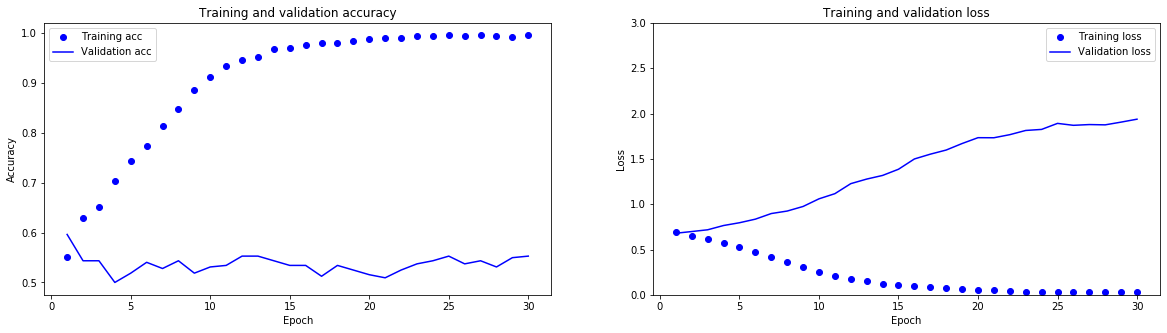

In [162]:
get_lstm(X_train, y_train, X_test, y_test, test_model=True)

# Model Builders

In [163]:
# Model imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid

### Analyzing last n fights using an LSTM

In [164]:
def get_lstm(x_train, y_train, x_val, y_val, test_model=False):
    model = Sequential()
    
    model.add(LSTM(50, 
                   input_shape=(5, 97),
                   recurrent_dropout=0.2)) #, return_sequences=True
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", 
                  optimizer=Adam(learning_rate=0.01), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=64,
                       epochs=30,
                       verbose=1)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model

### Analyzing last n fights using a Dense Neural Network

In [157]:
def get_dnn(x_train, y_train, x_val, y_val, params, test_model=False):
    
    model = Sequential()
    # Input Layer
    model.add(Dense(params["first_neuron"], 
                    activation=params['activation'], 
                    input_dim=X_train.shape[1]))
    
    model.add(Dropout(params['dropout']))
    
    # Hidden Layers
    hidden_layers(model, params, 1)
    
    # Output Layers
    model.add(Dense(1, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
                  
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    if test_model:
        model.summary()
        plot_training_results(history)
        

    return history, model

### Analyzing last n fights using a Convolutional Neural Network

In [158]:
def get_cnn(x_train, y_train, x_val, y_val, params, test_model=False):
    model = Sequential()
    
    # Convolutional Layers
    model.add(Conv1D(filters=params["num_filters"], kernel_size=params["kernel_size"], activation='relu', input_shape=(5, 97)))
    model.add(Conv1D(filters=params["num_filters"], kernel_size=params["kernel_size"], activation='relu'))
    model.add(Dropout(params['dropout']))
#     model.add(MaxPooling1D(pool_size=2))
    
    # Flatten Layers
    model.add(Flatten())
    model.add(Dense(params["flatten_layer"], activation='relu'))
#     model.add(Dense(params["flatten_layer"], activation='relu'))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model

## Helper Functions

In [159]:
def plot_training_results(history_obj):
    acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    fig, (accuracy_axis, loss_axis) = plt.subplots(1, 2, figsize=(20, 5))

    accuracy_axis.plot(epochs, acc, 'bo', label='Training acc')
    accuracy_axis.plot(epochs, val_acc, 'b', label='Validation acc')
    accuracy_axis.set_title('Training and validation accuracy')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.set_xlabel('Epoch')
    accuracy_axis.legend()

    loss_axis.plot(epochs, loss, 'bo', label='Training loss')
    loss_axis.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_axis.set_title('Training and validation loss')
    loss_axis.set_ylim(0, 3)
    loss_axis.set_ylabel('Loss')
    loss_axis.set_xlabel('Epoch')
    loss_axis.legend()
    fig.show()

## Extract numerical and categorical columns

In [160]:
# Get the first fight window and the first fight in that window
def get_column_types():
    num_cols = []
    cat_cols = []
    for fight in features[0][0]:
        feature_type = type(features[1][1][fight])
        if feature_type is not float and feature_type is not int:
            cat_cols.append(fight)
        else:
            num_cols.append(fight)
            
    return num_cols, cat_cols

In [161]:
x, y = get_column_types()